In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../../MNIST_data/", one_hot=True)

W0227 10:58:16.342242 4482684352 deprecation.py:323] From <ipython-input-1-3c4f46c1a93b>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0227 10:58:16.343158 4482684352 deprecation.py:323] From /Users/ianfan/anaconda3/envs/spinningup/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0227 10:58:16.343775 4482684352 deprecation.py:323] From /Users/ianfan/anaconda3/envs/spinningup/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will 

Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz


W0227 10:58:16.582597 4482684352 deprecation.py:323] From /Users/ianfan/anaconda3/envs/spinningup/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
import tensorflow as tf
import numpy as np
np.set_printoptions(suppress=True) 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [3]:
for folder in ['out/', 'model/']:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [4]:
mb_size = 32
Z_dim = 10
X_dim = mnist.train.images.shape[1] # 784
y_dim = mnist.train.labels.shape[1] # 10
eps = 1e-8
d_steps = 3

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1./tf.sqrt(in_dim/2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

X = tf.placeholder(tf.float32, shape=[None, X_dim])
y = tf.placeholder(tf.float32, shape=[None, y_dim])

D_W1 = tf.Variable(xavier_init([X_dim, 128]))
D_b1 = tf.Variable(tf.zeros(shape=[128]))

D_W2_gan = tf.Variable(xavier_init([128, 1]))
D_b2_gan = tf.Variable(tf.zeros(shape=[1]))

D_W2_aux = tf.Variable(xavier_init([128, y_dim]))
D_b2_aux = tf.Variable(tf.zeros(shape=[y_dim]))

theta_D = [D_W1, D_W2_gan,D_W2_aux, D_b1, D_b2_gan, D_b2_aux]

def discriminator(X):
    D_h1 = tf.nn.relu(tf.matmul(X, D_W1) + D_b1)
    out_gan = tf.nn.sigmoid(tf.matmul(D_h1, D_W2_gan) + D_b2_gan)
    out_aux = tf.matmul(D_h1, D_W2_aux) + D_b2_aux
#     out_aux = tf.nn.softmax(tf.matmul(D_h1, D_W2_aux) + D_b2_aux)
    return out_gan, out_aux

Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim + y_dim, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

def generator(z, c):
    inputs = tf.concat(axis=1, values=[z, c])
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)
    return G_prob

def categorical_crossentropy_with_logits(logit, y):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=y))

def categorical_crossentropy_with_prob(prob, y):
#     return tf.reduce_mean(tf.losses.log_loss(y, prob))
    return tf.reduce_mean(tf.reduce_sum(y*tf.log(prob), axis=1))

def sample_Z(m,n):
    return np.random.uniform(-1., 1., size=[m,n])

def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
    return fig

G_sample = generator(Z, y)
D_real, C_real = discriminator(X)
D_fake, C_fake = discriminator(G_sample)

D_loss_real = tf.reduce_mean(tf.log(D_real + eps) + tf.log(1. - D_fake + eps))
D_loss_fake = tf.reduce_mean(tf.log(D_fake + eps))

C_loss_real = categorical_crossentropy_with_logits(C_real, y)
C_loss_fake = categorical_crossentropy_with_logits(C_fake, y)

D_loss = -D_loss_real
G_loss = -D_loss_fake

C_loss = C_loss_real + C_loss_fake
# DC_loss = D_loss + C_loss
# GC_loss = G_loss + C_loss

# D_loss = -D_loss_real + C_loss_real
# G_loss = -D_loss_fake + C_loss_fake

D_solver = tf.train.AdamOptimizer(learning_rate=0.001).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer(learning_rate=0.001).minimize(G_loss, var_list=theta_G)
C_solver = tf.train.AdamOptimizer(learning_rate=0.001).minimize(C_loss, var_list=theta_D+theta_G)

D_real_predict = tf.cast(tf.greater_equal(D_real, 0.5), tf.float32)
D_real_correct = tf.cast(tf.equal(D_real_predict, np.ones_like([mb_size, 1])), tf.float32)
D_real_accuracy = tf.reduce_mean(D_real_correct)

D_fake_predict = tf.cast(tf.greater_equal(D_fake, 0.5), tf.float32)
D_fake_correct = tf.cast(tf.equal(D_fake_predict, np.zeros_like([mb_size, 1])), tf.float32)
D_fake_accuracy = tf.reduce_mean(D_fake_correct)

D_accuracy = 0.5 * (D_real_accuracy + D_fake_accuracy)

G_predict = tf.cast(tf.greater_equal(D_fake, 0.5), tf.float32)
G_correct = tf.cast(tf.equal(G_predict, np.ones_like([mb_size, 1])), tf.float32)
G_accuracy = tf.reduce_mean(G_correct)

W0227 10:58:17.015664 4482684352 deprecation.py:506] From /Users/ianfan/anaconda3/envs/spinningup/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py:187: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
# saver.restore(sess, "model/save_net.ckpt")

iter:0
[D loss:1.338 acc:0.6719] [G loss:2.442 acc:0.0]

iter:1000
[D loss:0.05846 acc:1.0] [G loss:5.583 acc:0.0]

iter:2000
[D loss:0.05107 acc:1.0] [G loss:4.212 acc:0.0]

iter:3000
[D loss:0.1407 acc:0.9844] [G loss:4.283 acc:0.0]

iter:4000
[D loss:0.3331 acc:0.9219] [G loss:3.083 acc:0.03125]

iter:5000
[D loss:0.1648 acc:0.9531] [G loss:3.229 acc:0.1562]

iter:6000
[D loss:0.3176 acc:0.9688] [G loss:3.296 acc:0.09375]

iter:7000
[D loss:0.4008 acc:0.9375] [G loss:3.177 acc:0.09375]

iter:8000
[D loss:0.226 acc:0.9375] [G loss:3.13 acc:0.125]

iter:9000
[D loss:0.4743 acc:0.9375] [G loss:4.004 acc:0.03125]

iter:10000
[D loss:0.6664 acc:0.875] [G loss:3.088 acc:0.09375]

iter:11000
[D loss:0.5354 acc:0.8906] [G loss:2.555 acc:0.03125]



KeyboardInterrupt: 

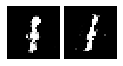

In [6]:
i=0
for it in range(1000000):    
    X_mb, y_mb =  mnist.train.next_batch(mb_size)
        
    _, D_l = sess.run([D_solver, D_loss], feed_dict={X:X_mb, y:y_mb, Z:sample_Z(mb_size, Z_dim)})
    _, G_l = sess.run([G_solver, G_loss], feed_dict={y:y_mb, Z:sample_Z(mb_size, Z_dim)})
    _, C_l = sess.run([C_solver, C_loss], feed_dict={X:X_mb, y:y_mb, Z:sample_Z(mb_size, Z_dim)})
    
    if it%1000==0:
        D_a = sess.run([D_accuracy], feed_dict={X:X_mb, Z:sample_Z(mb_size, Z_dim), y:y_mb})
        G_a = sess.run([G_accuracy], feed_dict={Z:sample_Z(mb_size, Z_dim), y:y_mb})
        
        print('iter:{}'.format(it))
        print('[D loss:{:.4} acc:{:.4}] [G loss:{:.4} acc:{:.4}]'.format(D_l, D_a[0], G_l, G_a[0]))
        print()
        
    if it%1000==0:
        for j in range(10):
            n_sample = 16

            Z_sample = sample_Z(n_sample, Z_dim)
            y_sample = np.zeros(shape=[n_sample, y_dim])
            y_sample[:,j] = 1

            samples = sess.run(G_sample, feed_dict={Z:Z_sample, y:y_sample})

            fig = plot(samples)
            plt.savefig('out/{}.png'.format((str(i)+'_'+str(j)).zfill(3)), bbox_inches='tight')
            plt.close(fig)
        i+=1
        
    if it%1000==0:
        save_path = saver.save(sess, "model/save_net.ckpt")